# CYQIQ Chain of Table for Multiple Tables

Authors: [Richárd Hruby](https://github.com/RichardHruby) and [Dániel Márk Szalai](https://github.com/zaturalma2) from [CYQIQ Inc.](https://cyqiq.ai)

### [TRY OUR HOSTED DEMO HERE](https://cyqiq-cot-demo-c27oq5sqda-uc.a.run.app/) 🔮

## Chain of Table

#### Chain of Table is a new technique introduced by researchers from Google and the University of California, San Diego. The method involves creating a series of SQL-like table manipulating actions such as select, group, sort etc. and add column. CoT also uses a method to extract data from poorly structured tables and adding them to the table in a new column resulting in a much more SQL/human/LLM friendly table.

#### The method then prompts an LLM to create a chain of actions/tables in a way that would ultimately lead to a much simpler table from which the provided question is easily answerable. Further details of CoT can be found in:

#### Wang, Zilong et al. Chain-of-Table: Evolving Tables in the Reasoning Chain for Table Understanding. 2024. arXiv: [2401.04398](https://arxiv.org/abs/2401.04398) [cs.CL].

#### A detailed example of the workings of CoT
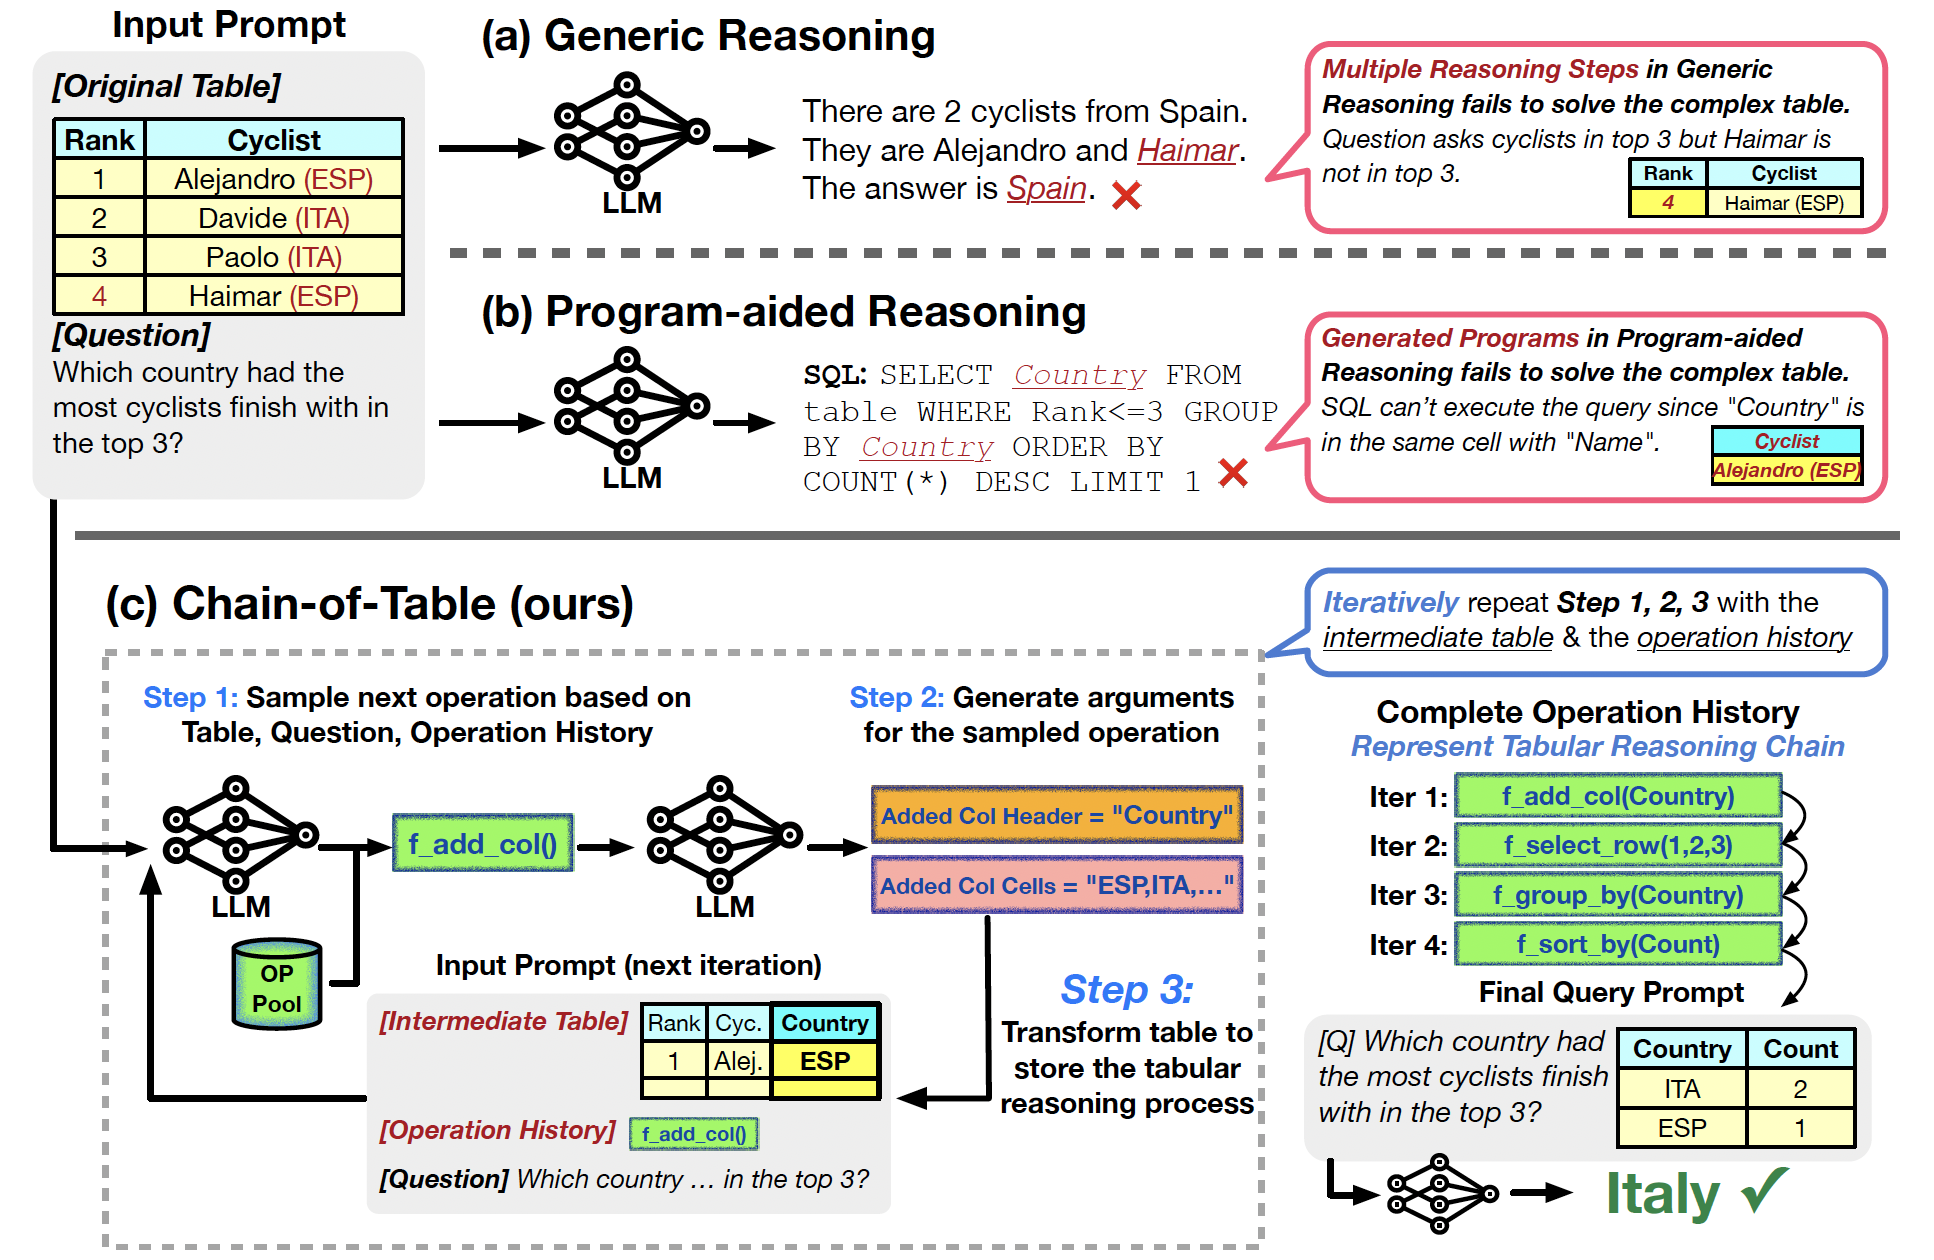

## A critique of CoT

#### CoT works with a chain of intermediate tables. The argument generation for the new column creation neccessitates the LLM's access to the complete table. This can lead to several unforseen errors such as context window overflow and hallucinating non-existent information for the new columns. Both problems become critical when the used table is large.

#### Further problems can be seen when we want to translate the CoT workflow into a more production ready environment. The method does not allow the joint handling of multiple tables and requires the developers to create their own parsers for the outputted commands of the LLM (this latter can be argued against: we may claim that the LLM will create the whole table, but once again we may run into context window and reliability (hallucination) problems, thus we believe it is better to execute the table manipulation codes outside the LLM's reach).

## CYQIQ -  CoT for multiple tables

#### In this notebook we introduce our state of the art CoT for multiple tables concept and a much more production ready implementation that utilizes [LangChain](https://python.langchain.com/docs/get_started/introduction) and [LangGraph](https://python.langchain.com/docs/langgraph). We will use Pandas as our table manager. Similarily to CoT we will prompt the LLM to create a chain of dataframe manipulating actions and we will perform the first outputted action and then supply the LLM with an intermediate table to generate the next action in the chain.

### 1. Importing the necessary libraries

You need to pip install the libraries: `pip install langchain langchain_openai langgraph langchainhub pandas tabulate`

Alternatively you can run: `pip install -r requirements.txt`

In [56]:
# basics
import json
import pandas as pd
import traceback

# pydantic
from typing import TypedDict, Annotated, Sequence
import operator

# self-defined functions
from util_functions import get_last_chains, save_new_chain

# langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain import hub

# langgraph
from langgraph.prebuilt import ToolExecutor, ToolInvocation
from langgraph.graph import StateGraph, END

### 2. Load your environmental variables:

#### This requires you to have a [.env] file next to this notebook. The [.env] file should have a blank filename and it should contain your access tokens. It's contents should look something like this:

- OPENAI_API_KEY="..."
- LANGCHAIN_API_KEY="..."
- LANGCHAIN_TRACING_V2=true
- LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
- LANGCHAIN_PROJECT="..."

In [57]:
from dotenv import load_dotenv

#### Environment ####
load_dotenv()

True

### 3. Get the list of dataframes:
#### Here we read our tables and transform them into a dictionary for ease of code execution. We also create a list of question strings. These are descriptors of the tables we may supply to the LLM. We use it in the prompting to help the LLM choose the relevant tables to a question. In production, these table descriptions are also generated by  LLM calls. We show a simple example with 6 tables and hardcoded description here.

In [105]:
# prep prompt temlate inputs
df_list = []
for i in range(6):
    df_list.append(pd.read_csv(f'data/coworker{i}.csv', index_col=0).copy())

# create df_dic for use by python eval() in evaluate_pandas_chain
df_dic = {}
for i, dataframe in enumerate(df_list):
    df_dic[f"df{i + 1}"] = dataframe

In [106]:
# create a string that describes each of the dataframes
questions_str = """
df1:  Choose the coworkers you recognize as the most valuable players (MVP) in the company due to their outstanding contribution to the company’s performance and productivity.
df2:  Choose the coworkers you think have the most untapped potential.
df3:  Who do you like to collaborate the most with?
df4:  With which coworkers do you feel the most tension or have the most conflicts?
df5:  Which coworker is the most difficult to collaborate with?
df6:  Metadata about the persons in the survey
"""

### 4. Get next action:
#### As mentioned earlier we will only perform a single action per generation cycle, this function helps retrieving the action from the LLM's output.

In [107]:
# parser for action chain
def get_action(actions):
    if "<BEGIN>" in actions:
        a = actions.split('->')[1].strip()
    else:
        a = actions.split('->')[0].strip()
    return  a

### 5. Define the tools the LLM may use

#### We define $2$ tools that the LLM may use to take actions and interact with the world (or in this case with our data). 
#### The $view\_pandas\_dataframes$ tool is responsible for providing information to the LLM about the dataframe, such as the column names and first few rows of data. Please note that in case the table is huge, this may completely fill up the LLM's context window. This is not a huge limitation as such tables can likely be split into several smaller, logically related tables and depending on the content of the table it needs hundreds of columns to cause such issues. In case splitting is not possible we suggest lowering the number of rows inputted to the LLM.

#### The $evaluate\_pandas\_chain$ tool is responsible to executing the generated action and returning the resulting intermediate dataframe's head as well as the action taken and the whole dataframe.

#### More detailed information about how tools work you may refer to the [documentation](https://python.langchain.com/docs/modules/agents/tools/).

In [108]:
# function to evaluate the next action in the chain
@tool
def evaluate_pandas_chain(
    chain: Annotated[str, "The pandas chain of actions . e.g. df1.groupby('age').mean() -> df1.sort_values() -> <END>"],
    inter=None):
    """Use this to execute the chain of pandas code on the dataframes"""

    name = "evaluate_pandas_chain"

    try:
        action = get_action(chain)#.replace(toreplace, 'inter')
        print('\n\naction: ', action)
        
        inter = eval(action, {"inter": inter, "df_dic": df_dic})
        
        if isinstance(inter, pd.DataFrame):
            intermediate = inter.head(50).to_markdown()
        else:
            intermediate = inter

        return intermediate, action, inter
                
    except Exception as e:
        return f"An exception occured: {traceback.format_exc()}", action, None

# function to look at dataframes 
@tool
def view_pandas_dataframes(
    df_list: Annotated[Sequence[str], "List of maximum 3 pandas dataframes you want to look at, e.g. [df1, df2, df3]"]):
    """Use this to view the head(10) of dataframes to answer your question"""

    name = "view_pandas_dataframes"

    markdown_str = "Here are .head(10) of the dataframes you requested to see:\n"
    for df in df_list:
        df_head = df_dic[df].head(10).to_markdown()
        markdown_str += f"{df}:\n{df_head}\n"

    markdown_str = markdown_str.strip()
    return markdown_str

tools = [evaluate_pandas_chain, view_pandas_dataframes]
tool_executor = ToolExecutor(tools)

functions = [convert_to_openai_function(t) for t in tools]

### 6. Create prompt:

#### We use a system message to explain the LLM what the task at hand is. We tell it how many dataframes it has access to and ask it to use the tools we defined. We then explain that the goal is to create a dataframe that helps to answer a certain question from the user. We then explain how we expect the generated action chain (this is also helpful in executing the code on our side OR using the $evaluate\_pandas\_chain$ tool) and we supply it with a few examples, explaining what logic it should follow for certain example questions. We also show it some past correct examples or "recipes" to which it may refer back in the future.

#### Finally, we show it the tools we just created, the descriptors of the dataframes and a log of the past few message between the agent and the user.

#### After we define the prompt template we complete it with the necessary information.

In [109]:
# we pull the prompt from langchain hub
SYSTEM_PROMPT = hub.pull("hrubyonrails/multi-cot").messages[0].prompt.template

# print the formatted prompt template?
print(SYSTEM_PROMPT)

You are working with {num_dfs} pandas dataframes in Python named df1, df2, etc. You
 should use the tools below to answer the question posed to you by performing a series of dataframe manipulating actions. The goal of these actions is to create a dataframe from which it is easy to answer the question from the multiple dataframes that is provided to you. You will also receive the steps completed so far and the current state of the dataframe. You must continue the chain until no more useful steps are possible at which point you finish the chain with <END>.

 You must start by looking at the dataframes you find relevant by using the view_pandas_dataframes tool.
Once you know what to do, you must create a chain of actions and execute it with the evaluate_pandas_chain tool.
 
Example chain input format:
<BEGIN> -> action1 ->
You must continue it like:
action2 -> action3 -> <END>
 
Always continue the chain with the above format for example:
 df_dic['df11'].merge(df_dic['df15'], on='personId

In [110]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            SYSTEM_PROMPT,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

prompt = prompt.partial(num_dfs=len(df_list))
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
prompt = prompt.partial(questions_str=questions_str)

# passing in past successful queries
chain_examples = ""
if(type(get_last_chains()) == pd.core.frame.DataFrame):
    for index, row in get_last_chains()[["query", "chain"]].iterrows():
        chain_examples += f'Question: {row["query"]}\nChain: {row["chain"]}\n\n'
prompt = prompt.partial(chain_examples=chain_examples)

### About LangGraph:

#### In simple terms: LangGraph allows us to create a statemachine. This machine will perform chains in each of its states. The crucial difference between LangGraph and creating multiple chains and then executing them one after the other is that LangGraph allows for circular or cyclic execution. This means that our statemachine can switch between states indefinitely based on some transition criteria until some stop condition is met. This is achieved by passing a state object between the nodes of the graph. Each node can perform actions and update the state object as needed. Further details about LangGraph can be found in the [documentation](https://python.langchain.com/docs/langgraph).

### 7. Define the statemachine

#### We first bind our tools to the model, this makes sure that the model knows that it has access to $2$ tools that it can call. We then define our state object $AgentState$. The object has $5$ fields: messages (annotated BaseMessage with add operator, meaning each node will add to it), actions: similarily to messages, but it is of a string type, inter: the intermediate dataframe (which is updated with each cycle as per the idea of CoT), question: the question to answer and memory: the past conversation betwwen the user and LLM.

In [111]:
# bind model
model = prompt | ChatOpenAI(model="gpt-4-0125-preview").bind_functions(functions)

# create graph state
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    actions: Annotated[Sequence[str], operator.add]
    inter: pd.DataFrame
    question: str
    memory: str

### 8. Define the graph elements

#### First we create a function, $should\_continue$, that will serve as a conditional edge between our nodes. Based on the current state multiple things might happen. In our case if the model thinks that additional steps are necessary then we want it to continue with the execution, if not we need it to stop.

#### Now we create our nodes. In LangGrapgh the nodes are either functions or runnables. Here we use functions as our nodes. The node $call\_model$ will serve as our entrypoint and will be used to determine our next action. In case the conditional edge decides to terminate, we exit from this node. In case we need to continue we go to $call\_tool$ node, which performs an action based on which function the LLM decided to use. We either look into some dataframes (which is a safe operation) or we execute a generated command (this can cause errors in case the command is not properly written so we added some exception handling and a self-correcting mechanism: in case the code fail to execute, we tell the LLM and ask it to correct the bad command).

In [112]:
# Define the function that determines whether to continue or not: conditional edge
def should_continue(state):
    messages = state['messages']
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    # Otherwise if there is, we continue with the call_tool node
    else:
        return "continue"

# Define the function that calls the model
def call_model(state):
    
    response = model.invoke(state)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function to execute tools
def call_tool(state):
    messages = state['messages']
    
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    
    
    tool_input = last_message.additional_kwargs["function_call"]["arguments"]
    

    tool_input_dict = json.loads(tool_input)
    tool_input_dict['inter'] = state['inter']

    if last_message.additional_kwargs["function_call"]["name"] == 'view_pandas_dataframes':
        
        # We construct an ToolInvocation from the function_call
        action = ToolInvocation(
            tool=last_message.additional_kwargs["function_call"]["name"],
            tool_input=tool_input_dict,
        )
        # We call the tool_executor and get back a response
        response = tool_executor.invoke(action)

        function_message = FunctionMessage(content=str(response), name=action.tool)
        return {"messages": [function_message]} # ,"actions": [attempted_action]}
    

    # if the tool is to evaluate chain the chain
    elif last_message.additional_kwargs["function_call"]["name"] == 'evaluate_pandas_chain':
   
        # We construct an ToolInvocation from the function_call
        action = ToolInvocation(
            tool=last_message.additional_kwargs["function_call"]["name"],
            tool_input=tool_input_dict,
        )
        # We call the tool_executor and get back a response
        response, attempted_action, inter = tool_executor.invoke(action)
            
        if "An exception occured:" in str(response):
            error_info = f"""
            You have previously performed the actions: 
            {state['actions']}

            Current action: 
            {attempted_action}

            Result .head(50): 
            {response}

            You must correct your approach and continue until you can answer the question:
            {state['question']}

            Continue the chain with the following format: action_i -> action_i+1 ... -> <END>
            """
            print(error_info)

            function_message = FunctionMessage(content=str(error_info), name=action.tool)
            return {"messages": [function_message]}
        
        else:

            success_info = f"""
            You have previously performed the actions: 
            {state['actions']}

            Current action: 
            {attempted_action}

            Result .head(50):
            {response}

            You must continue until you can answer the question:
            {state['question']}

            Continue the  chain with the following format: action_i -> action_i+1 ... -> <END>
            """
            print(success_info)

            # We use the response to create a FunctionMessage
            function_message = FunctionMessage(content=str(success_info), name=action.tool)
            # We return a list, because this will get added to the existing list
            return {"messages": [function_message], "actions": [attempted_action], "inter": inter}

### 9. Assemble the graph elements and create a proper graph structure

#### We now define our statemachine (StateGraph), add the nodes, set the entrypoint and add the conditional edge. So far we did not mention it, but after the $call\_tool$ node finishes we always return to the $call\_model$ node.

#### With the graph structure properly defined the only task left is to compile it, which will return a LangChain Runnable.

In [113]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END
    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge('action', 'agent')

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

### 10. Define the question

In [122]:
# let's try a few questions that involve multiple steps and different tables

user_query = "Return how many times Steven Rollins was selected for MVP. Return also the number of grades this employee received for each MVP reason."
# user_query = "Which team has the most votes for being difficult to work with?"

### 11. Call the model

In [123]:
inputs = {"messages": [HumanMessage(content=user_query)], "actions":["<BEGIN>"], "question": user_query, "memory": ""}

for output in app.stream(inputs, {"recursion_limit": 40}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        if key == "agent":
            print("🤖 Agent working...")
        elif key == "action":
            if value["messages"][0].name == "view_pandas_dataframes":
                print("🛠️ Current action:")
                print("`viewing dataframes`")
            else:
                if "actions" in value.keys():
                    print(f"🛠️ Current action:")
                    print(f"`{value['actions']}`")
                    print(f"Current output:")
                    print(value["inter"])
                else:
                    print(f"⚠️ An error occured, retrying...")
        else:
            print("🏁 Finishing up...")
            print(f"Final output:")
            print(value["inter"])
            print(f"Final action chain:")
            print(" -> ".join(value["actions"])  + ' -> <END>')

        print("---")
        pass


output_dict = output["__end__"]
agent_response = output_dict["messages"][-1].content
final_table = output_dict["inter"]
final_message = agent_response.replace('<END>', '')

🤖 Agent working...
---
🛠️ Current action:
`viewing dataframes`
---
🤖 Agent working...
---


action:  df_dic['df1'].merge(df_dic['df6'], on='personId')

            You have previously performed the actions: 
            ['<BEGIN>']

            Current action: 
            df_dic['df1'].merge(df_dic['df6'], on='personId')

            Result .head(50):
            |    | Choose the coworkers you recognize as the most valuable players (MVP) in the company due to their outstanding contribution to the company’s performance and productivity.   | personId                             | Summary                          | description                                                                                                                                                                                                                                                                                                                           | name            | team                      | depa

In [124]:
# Let's print the final message
print(final_message)

Steven Rollins was selected for MVP a total of 102 times. The number of grades he received for each MVP reason is as follows:

- Can cope with stress: 4 times
- Cares for others: 12 times
- Cares for the team: 13 times
- Has an appropriate work attitude: 9 times
- Has good communication skills: 13 times
- Has knowledge and experience: 9 times
- Has leadership skills: 15 times
- Is embedded in the company: 13 times
- Is self-sacrificing: 3 times
- Shows motivation and enthusiasm: 11 times




In [125]:
print(final_table)

Summary
Can cope with stress                 4
Cares for others                    12
Cares for the team                  13
Has an appropriate work attitude     9
Has good communication skills       13
Has knowledge and experience         9
Has leadership skills               15
Is embedded in the company          13
Is self-sacrificing                  3
Shows motivation and enthusiasm     11
dtype: int64
